In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# 01. Reading CSV with LGBM(best model) predictions

In [3]:
# reading csv with LGBM predictions
df = pd.read_csv("/content/drive/MyDrive/datasets/cs2/train_FE_pred.csv")

In [4]:
print(df.shape)
df.head(2)

(200000, 403)


,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,...,var_161_FE,var_162_FE,var_163_FE,var_164_FE,var_165_FE,var_166_FE,var_167_FE,var_168_FE,var_169_FE,var_170_FE,var_171_FE,var_172_FE,var_173_FE,var_174_FE,var_175_FE,var_176_FE,var_177_FE,var_178_FE,var_179_FE,var_180_FE,var_181_FE,var_182_FE,var_183_FE,var_184_FE,var_185_FE,var_186_FE,var_187_FE,var_188_FE,var_189_FE,var_190_FE,var_191_FE,var_192_FE,var_193_FE,var_194_FE,var_195_FE,var_196_FE,var_197_FE,var_198_FE,var_199_FE,lgbm_predictions
0,train_0,0,8.9255,-6.7863,2.9252,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,3.1821,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,14.0137,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,0.5745,12.8287,0.3587,...,25,3,5,1,2,22,2,3,34,9,4,2,2,2,7,3,2,3,4,3,7,3,4,2,1,6,3,4,8,3,8,9,4,9,5,5,14,5,2,0.006779
1,train_1,0,11.5006,-4.1473,-0.4032,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,8.0585,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,14.0239,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697,2.4354,0.8194,16.5346,8.4135,12.4205,-0.1780,...,38,5,1,2,3,31,1,11,24,1,1,1,2,2,4,1,5,1,1,3,5,1,4,2,5,4,1,5,14,8,5,9,2,4,4,4,21,6,2,0.367490


# 02. Probability distribution

### Observations: looking at the below plot we can play around with the threshold and instead of using 0.5 to decide the class 0 or 1, we can probably can use 0.4 as we can see class 0(in blue) falls exponentially after ~0.4

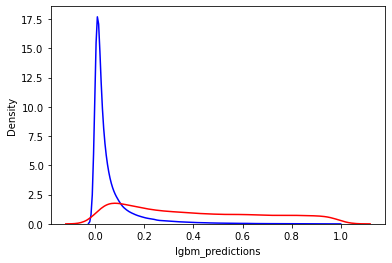

In [5]:
# lets look at the probability distribution
sns.distplot(df.lgbm_predictions[df.target==0], color="blue", hist=False)
sns.distplot(df.lgbm_predictions[df.target==1], color="red", hist=False)
plt.show()

In [6]:
# using 0.4 threshold to bucket probabilities into classes
df["lgbm_target"] = [0 if x<=0.4 else 1 for x in df.lgbm_predictions]

# 03. Confusion Matrix

### Observations: Since the dataset is not balanced we can see that class 1 which is the minority has not performed well. Need to look at "False Negatives"

Text(0.5, 1.0, 'Confusion Matrix')

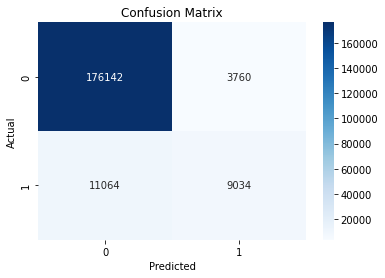

In [7]:
# lets look at the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
cm = confusion_matrix(df.target, df.lgbm_target)
sns.heatmap(cm, annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# 04. Most misclassified class

### Observations: As we can see below class 1 is the most misclassified class - one reason being low training datapoints for class 1

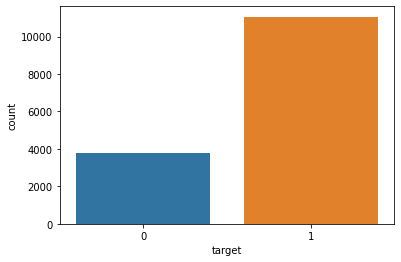

In [8]:
# lets look at the most misclassified class
y_err = df.target[df.target != df.lgbm_target]
sns.countplot(y_err)

# 05. Deepdive into class 1

### Task: Finding the difference/pattern between correctly classified and mis-classified class 1's

In [9]:
# Creating a dataframe with ground truth targets as 1
df_class_1 = df[df.target==1].copy()
print(df_class_1.shape)
df_class_1.head(2)

(20098, 404)


,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,...,var_162_FE,var_163_FE,var_164_FE,var_165_FE,var_166_FE,var_167_FE,var_168_FE,var_169_FE,var_170_FE,var_171_FE,var_172_FE,var_173_FE,var_174_FE,var_175_FE,var_176_FE,var_177_FE,var_178_FE,var_179_FE,var_180_FE,var_181_FE,var_182_FE,var_183_FE,var_184_FE,var_185_FE,var_186_FE,var_187_FE,var_188_FE,var_189_FE,var_190_FE,var_191_FE,var_192_FE,var_193_FE,var_194_FE,var_195_FE,var_196_FE,var_197_FE,var_198_FE,var_199_FE,lgbm_predictions,lgbm_target
13,train_13,1,16.3699,1.5934,2.3287,3.0553,7.9854,23.1168,1.2800,10.3728,4.2077,6.9854,3.2922,14.1718,19.9806,-11.3409,7.3345,6.6171,3.4385,10.8491,2.8266,-3.6481,0.6314,13.8302,-2.5018,-2.3101,13.7999,11.2664,11.7174,-0.4719,7.8367,3.9109,12.4349,11.9001,0.1655,-5.0549,17.7638,2.7925,11.7535,0.4436,...,6,5,4,3,28,2,1,32,6,3,3,5,4,4,1,5,2,2,5,6,2,3,2,2,3,2,2,9,4,6,5,4,2,4,3,12,5,1,0.447790,1
29,train_29,1,5.3301,-2.6064,6.8278,-18.6567,16.6038,28.9214,1.5178,11.2205,4.8288,12.4790,13.3789,13.9964,11.8464,1.3898,9.6306,6.3321,5.9595,5.8135,3.9010,4.3564,1.8298,21.8669,9.3199,6.9396,14.0957,18.2151,11.3680,-4.8909,-4.3503,4.9419,12.7444,13.2954,5.5083,-1.8983,12.4850,12.3335,13.2595,0.6290,...,5,1,2,1,34,2,2,22,3,1,3,2,1,4,3,6,2,3,5,5,7,2,4,2,7,2,6,14,1,4,9,2,2,8,2,9,3,2,0.179549,0


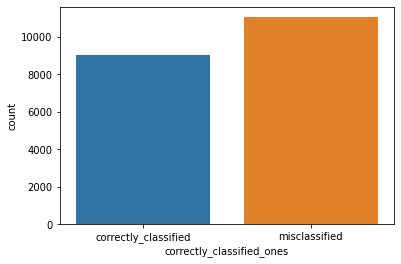

In [10]:
# adding a column which indicates if the classification for class 1 is correct or not
df_class_1["correctly_classified_ones"] = ["correctly_classified" if x==1 else "misclassified" for x in df_class_1.lgbm_target]
sns.countplot(df_class_1["correctly_classified_ones"])

In [11]:
df_class_1.head()

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,...,var_163_FE,var_164_FE,var_165_FE,var_166_FE,var_167_FE,var_168_FE,var_169_FE,var_170_FE,var_171_FE,var_172_FE,var_173_FE,var_174_FE,var_175_FE,var_176_FE,var_177_FE,var_178_FE,var_179_FE,var_180_FE,var_181_FE,var_182_FE,var_183_FE,var_184_FE,var_185_FE,var_186_FE,var_187_FE,var_188_FE,var_189_FE,var_190_FE,var_191_FE,var_192_FE,var_193_FE,var_194_FE,var_195_FE,var_196_FE,var_197_FE,var_198_FE,var_199_FE,lgbm_predictions,lgbm_target,correctly_classified_ones
13,train_13,1,16.3699,1.5934,2.3287,3.0553,7.9854,23.1168,1.2800,10.3728,4.2077,6.9854,3.2922,14.1718,19.9806,-11.3409,7.3345,6.6171,3.4385,10.8491,2.8266,-3.6481,0.6314,13.8302,-2.5018,-2.3101,13.7999,11.2664,11.7174,-0.4719,7.8367,3.9109,12.4349,11.9001,0.1655,-5.0549,17.7638,2.7925,11.7535,0.4436,...,5,4,3,28,2,1,32,6,3,3,5,4,4,1,5,2,2,5,6,2,3,2,2,3,2,2,9,4,6,5,4,2,4,3,12,5,1,0.447790,1,correctly_classified
29,train_29,1,5.3301,-2.6064,6.8278,-18.6567,16.6038,28.9214,1.5178,11.2205,4.8288,12.4790,13.3789,13.9964,11.8464,1.3898,9.6306,6.3321,5.9595,5.8135,3.9010,4.3564,1.8298,21.8669,9.3199,6.9396,14.0957,18.2151,11.3680,-4.8909,-4.3503,4.9419,12.7444,13.2954,5.5083,-1.8983,12.4850,12.3335,13.2595,0.6290,...,1,2,1,34,2,2,22,3,1,3,2,1,4,3,6,2,3,5,5,7,2,4,2,7,2,6,14,1,4,9,2,2,8,2,9,3,2,0.179549,0,misclassified
63,train_63,1,7.7072,0.0183,-5.1448,-4.1801,16.6054,21.7478,1.4524,14.0989,3.9095,12.8726,20.1333,14.5759,16.5122,11.0835,-0.5531,4.1864,0.8888,15.7983,1.5273,-4.6545,1.6415,29.3572,7.7148,12.2595,14.0503,22.6011,13.6073,-2.8966,12.7795,1.0744,12.5220,14.5459,1.0820,-5.5626,14.2895,9.0144,13.8080,-0.0658,...,5,1,6,8,2,4,26,2,2,2,1,3,2,3,13,1,6,3,11,1,6,1,3,7,2,1,12,3,3,4,6,3,5,3,4,2,1,0.808093,1,correctly_classified
65,train_65,1,10.5358,-2.5439,-10.7504,-18.7344,10.4687,18.7029,1.9164,13.0508,4.0557,8.0012,20.6690,13.9802,9.1121,7.7587,4.2034,8.0204,5.1012,4.3210,2.8750,-0.2201,1.1451,15.4022,10.5331,-4.5284,13.6021,33.7952,10.5927,-2.0855,4.3777,9.5419,11.9902,13.7393,1.5457,1.2202,19.3172,4.2864,13.1929,0.6811,...,3,1,1,21,2,3,24,3,5,2,3,3,3,3,4,1,2,3,4,3,5,1,2,4,3,3,11,4,5,5,1,2,6,2,13,4,3,0.862816,1,correctly_classified
71,train_71,1,6.7547,2.5973,-11.4237,2.5289,13.9396,28.6498,1.8360,11.4266,5.9206,7.1707,13.4091,14.1995,15.9737,-8.6036,3.3659,6.8131,5.3211,9.9834,4.8925,2.5266,1.5234,12.2391,-3.6880,6.4240,13.9394,9.3161,14.1742,9.8378,8.6804,5.3292,12.6228,12.3859,0.2725,-3.0042,18.8814,3.6480,11.1138,0.5677,...,4,5,3,24,3,6,8,2,1,3,3,2,7,1,6,1,1,1,2,1,1,4,4,2,1,7,11,1,3,5,4,2,1,2,6,5,3,0.445729,1,correctly_classified


In [12]:
# specifying features and target so that we can use pca & t-sne for further analysis and find patterns between correctly & mis classified class 1's 
features = [c for c in df_class_1.columns if c not in ['ID_code', 'target', 'lgbm_predictions', 'lgbm_target', 'correctly_classified_ones']]
target = df_class_1['correctly_classified_ones']

## 5.1. PCA - we use PCA before t-sne is due to speed as there are close to 400 features that we need to reduce. We reduce features to an extent where it can explain 95% variance

In [ ]:
# Dim reduction to a point where we can explain 95% of variance - this should be good for further t-sne groupings
from sklearn.decomposition import PCA
pca = PCA(.95)
pca_result = pca.fit_transform(df_class_1[features].values)
print(pca_result.shape)

(20098, 4)


## 5.2. T-SNE: We use TSNE to reduce to 2 dim so that we can visulize and see if the mis-classifications are clustered and show some patterns which we can then zoom into

### Observations: Unfortunately this training dataset is so well feature engineered before its put on kaggle that the misclassification are spread evenly without showing much of a pattern. 

In [ ]:
# t-sne
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20098 samples in 0.016s...
[t-SNE] Computed neighbors for 20098 samples in 1.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20098
[t-SNE] Computed conditional probabilities for sample 2000 / 20098
[t-SNE] Computed conditional probabilities for sample 3000 / 20098
[t-SNE] Computed conditional probabilities for sample 4000 / 20098
[t-SNE] Computed conditional probabilities for sample 5000 / 20098
[t-SNE] Computed conditional probabilities for sample 6000 / 20098
[t-SNE] Computed conditional probabilities for sample 7000 / 20098
[t-SNE] Computed conditional probabilities for sample 8000 / 20098
[t-SNE] Computed conditional probabilities for sample 9000 / 20098
[t-SNE] Computed conditional probabilities for sample 10000 / 20098
[t-SNE] Computed conditional probabilities for sample 11000 / 20098
[t-SNE] Computed conditional probabilities for sample 12000 / 20098
[t-SNE] Computed conditional probabilities for sa

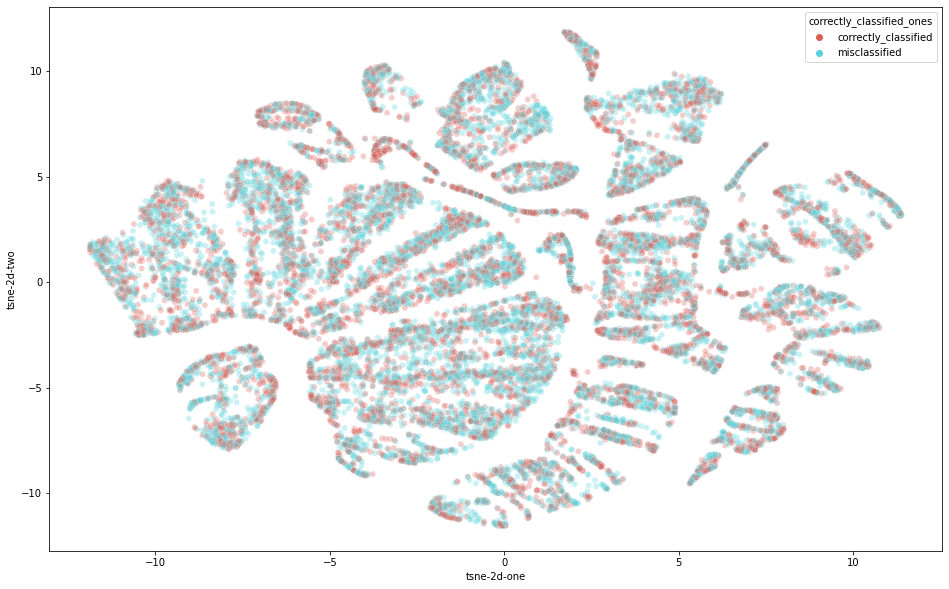

In [ ]:
df_class_1['tsne-2d-one'] = tsne_results[:,0]
df_class_1['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="correctly_classified_ones",
    palette=sns.color_palette("hls", 2),
    data=df_class_1,
    legend="full",
    alpha=0.3
)

## 5.3. Distribution of class 1 mis-classified points

### Task: Lets check the distribution of features between the 2 classes and find a pattern - we will use "correctly_classified_ones" as target here

### Observations:
#### 01. Below we use logistic regression to check if the dist. of correctly classified and misclassified points are the same - Since we get an AUC score of 0.75, the distribution of misclassified 1's is different

#### 02. We use XGboost to get top 15 features and get their dist. - we see based on the charts the distribution is definately different

In [13]:
x = df_class_1[features]
y = target
# converting to numeric to feed in logistic regression model
y_numeric = [1 if x=="correctly_classified" else 0 for x in y]
print(y[:5].values, "\n"
      , y_numeric[:5])

['correctly_classified' 'misclassified' 'correctly_classified'
 'correctly_classified' 'correctly_classified'] 
 [1, 0, 1, 1, 1]


In [16]:
# using logistic regression to see if distributions of train and test datasets are the same
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

lr = LogisticRegression()
lr.fit(x, y_numeric)
y_hat = lr.predict(x)
print(roc_auc_score(y_numeric, y_hat))

0.7588798466978848
CPU times: user 3 s, sys: 434 ms, total: 3.44 s
Wall time: 1.87 s


In [17]:
# video reference for ideas: https://www.youtube.com/watch?v=kPtotLrFCVw

In [18]:
# applying xgboost to get top features
import numpy as np
from xgboost import XGBClassifier

feat_names = list(x.columns)
xgb = XGBClassifier()
xgb = xgb.fit(x,y_numeric)  

In [19]:
# getting feature importances
fi = xgb.feature_importances_
di = {}
for i in range(len(feat_names)):
  di[feat_names[i]] = fi[i]

In [20]:
# sort desending
from operator import itemgetter
di_sorted = sorted(di.items(), key=itemgetter(1), reverse=True)

In [21]:
# top 15 features for further analysis
top_15_features = [elem[0] for elem in di_sorted[:15]]

In [22]:
# custom function to get dist. plots
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,10,figsize=(18,10))

    for feature in features:
        i += 1
        plt.subplot(2,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

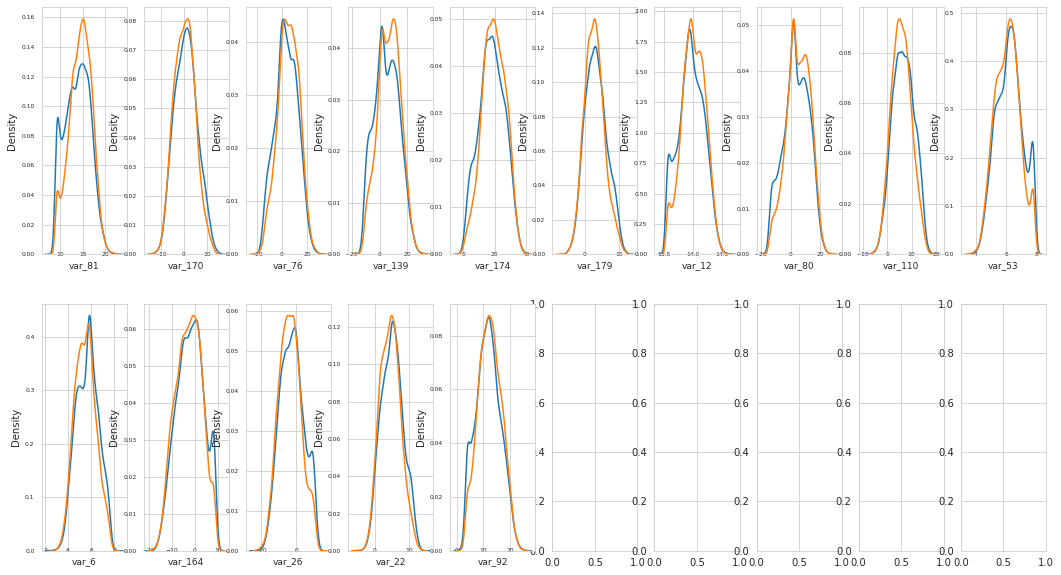

In [23]:
# distribution plots
t0 = df_class_1.loc[df_class_1['correctly_classified_ones'] == "correctly_classified"]
t1 = df_class_1.loc[df_class_1['correctly_classified_ones'] == "misclassified"]
features = top_15_features
plot_feature_distribution(t0, t1, 'correctly_classified', 'misclassified', features)

## 5.4. Checking distributions of classes - misclassified 1's and 0's

### Observations: As we can see below the distributions of misclassified 1's and 0's are mostly the same and hence the model is misclassifying class 1 as class 0 for some datapoints.

In [24]:
# creating a dataframe of misclassified ones
df_misclassified_ones = df_class_1[df_class_1.correctly_classified_ones == "misclassified"]

In [25]:
# top 15 features and target
top_15_target = top_15_features+["target"]
print(top_15_target)

['var_81', 'var_170', 'var_76', 'var_139', 'var_174', 'var_179', 'var_12', 'var_80', 'var_110', 'var_53', 'var_6', 'var_164', 'var_26', 'var_22', 'var_92', 'target']


In [26]:
df_mix = pd.concat([df[top_15_target], df_misclassified_ones[top_15_target]])
df_mix.shape

(211064, 16)

<Figure size 432x288 with 0 Axes>

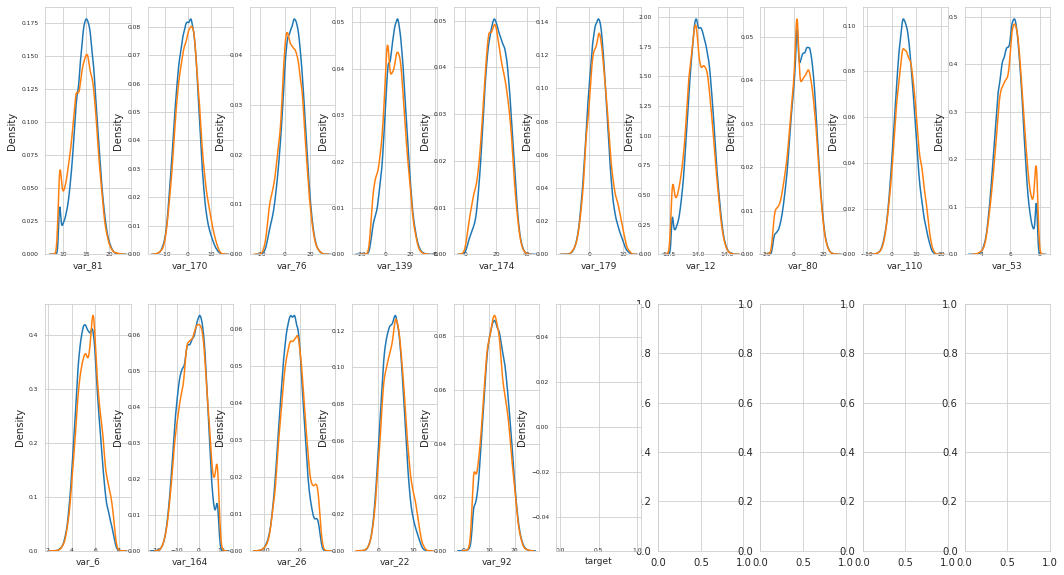

In [27]:
# distribution plots
t0 = df_mix.loc[df_mix['target'] == 0]
t1 = df_mix.loc[df_mix['target'] == 1]
features = top_15_target
plot_feature_distribution(t0, t1, '0', '1', features)

# Final Observations:
## Using basic statistics and some visulization we can come to the below conclusion:

- Using dimentionality reduction PCA & T-SNE we can come to conclusion that the misclassifed and correctly classified class 1 do not show any patterns and are spread evenly across, hence no outliar detected for misclassified class 1 points.

- Looking deeper into the distributions of top n features we can see that the misclassified class 1 points are very similar to class 0 distribution and hence the misclassification. To correct this we need to look at the misclassified points or remove them from the dataset and then check if the scores improve or are the class labels for these points are not correct and have an error when they have been labelled